In [254]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import missingno as msno
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neural/neural3.csv
/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv
/kaggle/input/samplesubmission/sample_submission.csv
/kaggle/input/newneural/neural3 (1).csv


In [255]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [256]:
train_data.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1794,1908_01,Mars,False,E/115/P,TRAPPIST-1e,18.0,False,1218.0,0.0,34.0,1095.0,0.0,Herms Chcak,False
4590,4891_01,Europa,True,B/194/S,TRAPPIST-1e,22.0,False,0.0,0.0,0.0,0.0,0.0,Cella Ambleetive,True
6161,6503_01,Earth,False,F/1347/P,TRAPPIST-1e,27.0,False,0.0,1.0,20.0,0.0,1363.0,Billia Mcfarley,False
14,0011_01,Earth,False,F/2/P,TRAPPIST-1e,28.0,False,8.0,974.0,12.0,2.0,7.0,Elle Bertsontry,True
5805,6141_01,Earth,False,F/1174/S,PSO J318.5-22,17.0,False,0.0,20.0,0.0,14.0,884.0,Natald Haydenzier,False


In [257]:
test_data.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
3606,7862_01,Earth,True,G/1266/P,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,Milda Delazarson
2602,5690_01,Mars,False,F/1085/S,TRAPPIST-1e,24.0,False,1163.0,NaN,1.0,0.0,124.0,Per Chité
2753,6079_01,Earth,True,G/986/P,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Charry Jenson
3430,7482_01,Mars,True,F/1547/P,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,0.0,0.0,Oats Blie
3502,7603_01,Earth,False,F/1578/P,TRAPPIST-1e,18.0,False,0.0,1381.0,0.0,0.0,3.0,Bobbyn Cardners


In [258]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [259]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [260]:
print(f' Shape of train data : \n', train_data.shape)
print(f' Shape of test data : \n', test_data.shape)

 Shape of train data : 
 (8693, 14)
 Shape of test data : 
 (4277, 13)


In [261]:
# train_data["Transported"] = train_data["Transported"].replace(to_replace = [False, True], 
#                                   value = ["No", "Yes"])
# train_data["VIP"] = train_data["VIP"].replace(to_replace = [False, True], 
#                                   value = ["No", "Yes"]).astype("object")
# train_data["CryoSleep"] = train_data["CryoSleep"].replace(to_replace = [False, True], 
#                                   value = ["No", "Yes"]).astype("object")

In [262]:
# print("The number of rows in train data is {0}, and the number of columns in train data is {1}".
#       format(train_data.shape[0], train_data.shape[1]))
      
# print("The number of rows in test data is {0}, and the number of columns in test data is {1}".
#       format(test_data.shape[0], test_data.shape[1]))

In [263]:
train_data.describe().T.style.background_gradient(cmap = "summer")

,count,mean,std,min,25%,50%,75%,max
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000


In [264]:
# #not_billed_data = train_data[(train_data["RoomService"] == 0)
#                          & (train_data["Spa"] == 0)
#                          & (train_data["FoodCourt"] == 0) 
#                          & (train_data["ShoppingMall"] == 0)
#                          & (train_data["VRDeck"] == 0)]

# mean_age = not_billed_data["Age"].mean().round()
# print("There are {0} passengers on the board of the spaceship who have not spent money, their average age is {1}"
#       .format(not_billed_data.shape[0], mean_age))

In [265]:
# train_data.describe(include = "object").T

In [266]:
# train_data.isnull().sum()

<AxesSubplot:>

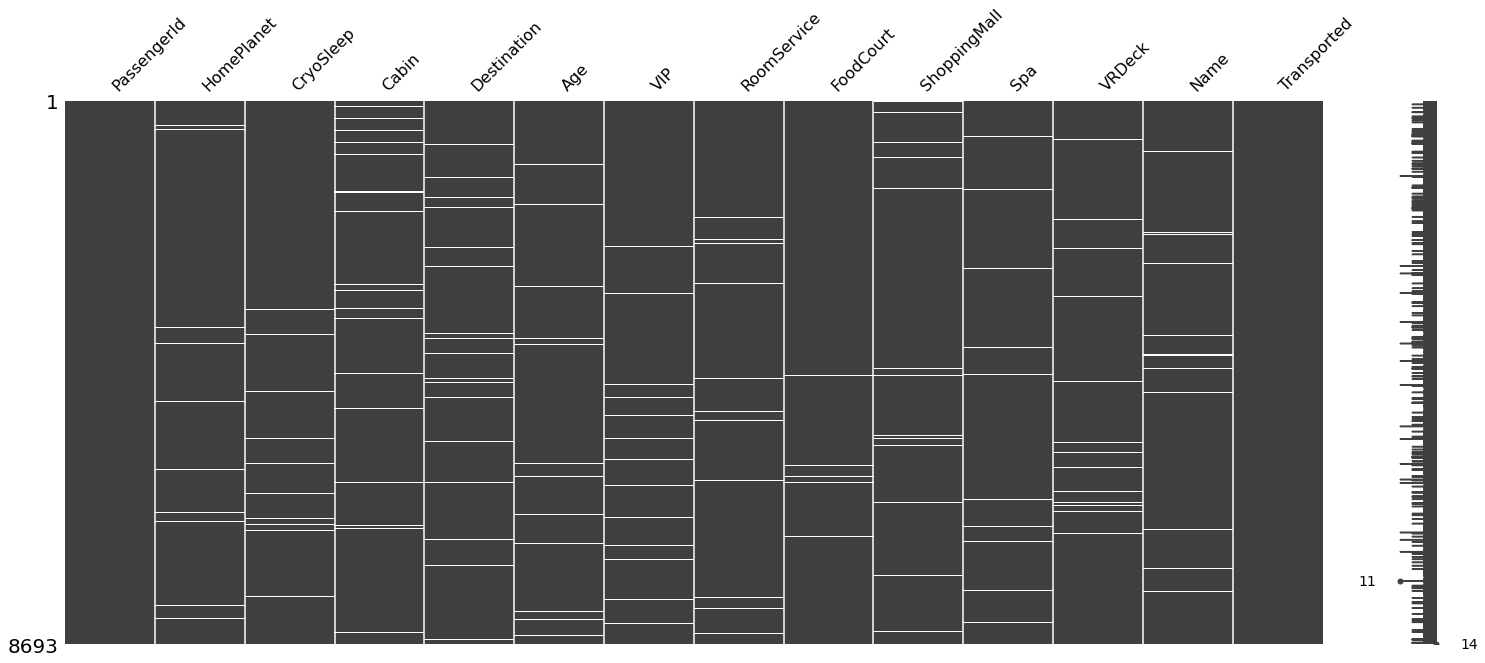

In [267]:
msno.matrix(train_data)

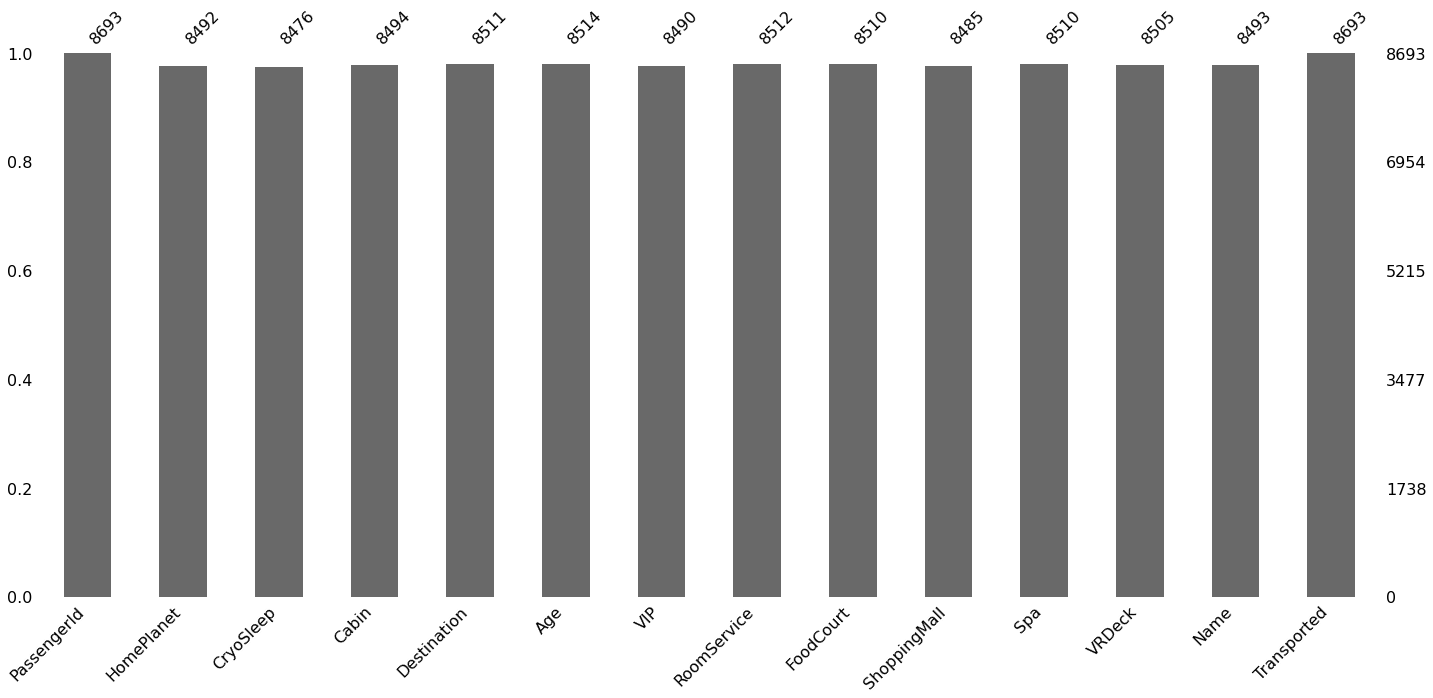

In [268]:
msno.bar(train_data);

In [269]:
# numeric_data = [column for column in train_data.select_dtypes(["int", "float"])]
# categoric_data = [column for column in train_data.select_dtypes(exclude = ["int", "float"])]
# test_categoric_data = [column for column in test_data.select_dtypes(exclude = ["int", "float"])]

# for col in numeric_data:
#     train_data[col].fillna(train_data[col].median(), inplace = True)
#     test_data[col].fillna(test_data[col].median(), inplace = True)
    
# #replace missing values in each categorical column with the most frequent value
# for col in categoric_data:
#     train_data[col].fillna(train_data[col].value_counts().index[0], inplace = True)
# for col in test_categoric_data:
#     test_data[col].fillna(test_data[col].value_counts().index[0], inplace = True) 

In [270]:
# train_data.isnull().sum().sum() + test_data.isnull().sum().sum()

In [271]:
print("Columns in object data type: \n",
      list((train_data.select_dtypes("object").columns)))

Columns in object data type: 
 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


In [272]:
print("Columns in numeric data type: \n",
      list((train_data.select_dtypes(["int", "float"]).columns)))

Columns in numeric data type: 
 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [273]:
print("Class frequencies of 'home_planet' variable: \n\n",
      train_data["HomePlanet"].value_counts())
print("___________________________________________")

print("Class frequencies of 'destination' variable: \n\n",
      train_data["Destination"].value_counts())

Class frequencies of 'home_planet' variable: 

 Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
___________________________________________
Class frequencies of 'destination' variable: 

 TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64


In [274]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [275]:
# not_billed_data = train_data[(train_data["RoomService"] == 0)
#                          & (train_data["Spa"] == 0)
#                          & (train_data["FoodCourt"] == 0) 
#                          & (train_data["ShoppingMall"] == 0)
#                          & (train_data["VRDeck"] == 0)]

# mean_age = not_billed_data["Age"].mean().round()
# print("There are {0} passengers on the board of the spaceship who have not spent money, their average age is {1}"
#       .format(not_billed_data.shape[0], mean_age))

In [276]:
# train_data.describe(include = "object").T

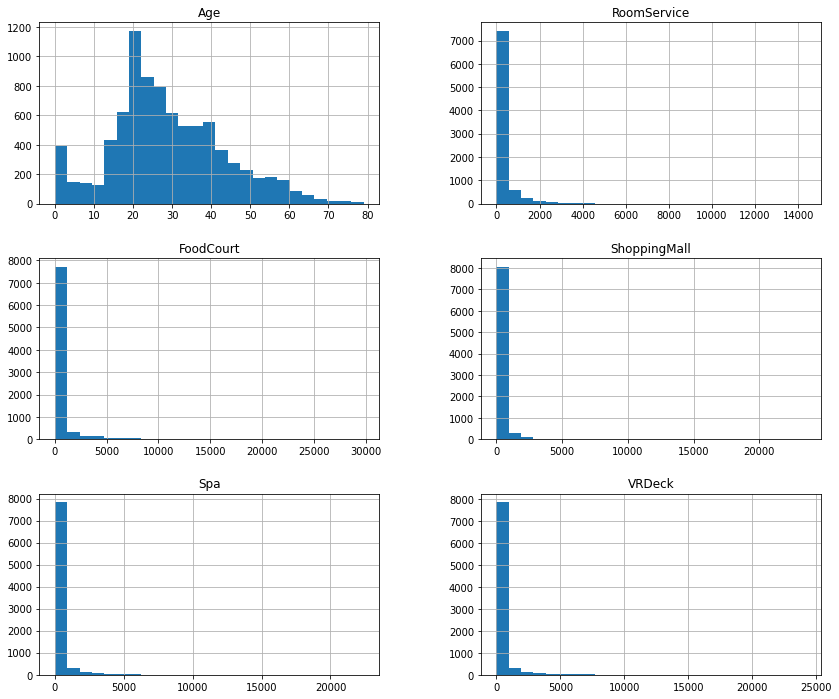

In [277]:
train_data.hist(bins = 25, figsize = (14, 12))
plt.show()

In [278]:
# numeric_data = [column for column in train_data.select_dtypes(["int", "float"])]

# for column in numeric_data:
#   df_anova = train_data[[column,'Transported']]
#   grouped_anova = df_anova.groupby(['Transported'])
#   f_value, p_value = stats.f_oneway(grouped_anova.get_group('Yes')[column],
#                                     grouped_anova.get_group('No')[column])
#   result = ""
#   if p_value < 0.05:
#     result = "{} is important feature for prediction".format(column)
#   else:
#     result = "{} is not an important feature for prediction".format(column)
#   print(result)

In [279]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [280]:
# def outlier_detection_train(df, n, columns):
#     rows = []
#     will_drop_train = []
#     for col in columns:
#         Q1 = np.nanpercentile(df[col], 25)
#         Q3 = np.nanpercentile(df[col], 75)
#         IQR = Q3 - Q1
#         outlier_point = 1.5 * IQR
#         rows.extend(df[(df[col] < Q1 - outlier_point)|(df[col] > Q3 + outlier_point)].index)
#     for r, c in Counter(rows).items():
#         if c >= n: will_drop_train.append(r)
#     return will_drop_train

In [281]:
# will_drop_train = outlier_detection_train(train_data, 5 ,train_data.select_dtypes(["float", "int"]).columns)
# train_data.drop(will_drop_train, inplace = True, axis = 0)

In [282]:
# # Create 'deck' and 'side' features from 'cabin' column

# train_data["deck"] = train_data["Cabin"].apply(lambda x:str(x).split("/")[0])
# test_data['deck'] = test_data['Cabin'].apply(lambda x:str(x).split('/')[0])

# train_data["side"] = train_data["Cabin"].apply(lambda x: x.split("/")[2])
# test_data["side"] = test_data["Cabin"].apply(lambda x: x.split("/")[2])

In [283]:
# # Financial situation of passengers

# train_data["total_bill"] = train_data["RoomService"] + train_data["FoodCourt"] + train_data["ShoppingMall"] + train_data["Spa"] + train_data["VRDeck"] 
# train_data["financial_situation"] = train_data["total_bill"].apply(lambda x: "poor" if x < 5000 else ("middle" if x>5000 and x<20000 else "rich"))

# test_data["total_bill"] = test_data["RoomService"] + test_data["FoodCourt"] + test_data["ShoppingMall"] + test_data["Spa"] + test_data["ShoppingMall"] 
# test_data["financial_situation"] = test_data["total_bill"].apply(lambda x: "poor" if x < 5000 else ("middle" if x>5000 and x<20000 else "rich"))

In [284]:
# # create new feature ('in_group') from "PassengerID" variable

# train_data["group_id"] = train_data["id"].apply(lambda x: x.split("_")[0])
# test_data["group_id"] = test_data["id"].apply(lambda x: x.split("_")[0])
# train_data["group_number"] = train_data["id"].apply(lambda x: x.split("_")[1])
# test_data["group_number"] = test_data["id"].apply(lambda x: x.split("_")[1])

# train_g = train_data[train_data["group_id"].duplicated()]["group_id"]
# test_g = test_data[test_data["group_id"].duplicated()]["group_id"]
# train_data["in_group"] = train_data["group_id"].apply(lambda x: x in train_g.values)
# test_data["in_group"] = test_data["group_id"].apply(lambda x: x in test_g.values)

In [285]:
# # Function to extract cabin grp and side 
# def cabin_split(x):
#     ## try and exception is used to navigate through the nan values
#     try:
#         u= x.split('/')
#         return str(u[0] + u[2])
#     except AttributeError as e:
#         return x

# # Extract cabin grp and side
# for data in [test_data, train_data]:
#     data["Cabin_grp"] = data.Cabin.apply(cabin_split)

In [286]:
# # Function fill the Cabin_grp
# for data in [train_data, test_data]:
#     data.Cabin_grp.fillna(method="pad", inplace=True)

# # Function to Fill the Cabin from the Carbin_grp    
# def fill_cabin(data):
#     ## try and exception is used to navigate through the nan values
#     try:
#         a = data.str.split('')
#         return str(a[1] + "/" + str(np.random.choice(a=1500, size=1)[0])+ "/" + a[2])
#     except AttributeError as e:
#         return data

# # Fill the Cabin from the Carbin_grp
# for data in [test_data, train_data]:
#     for index, value in enumerate(list(data.Cabin.isna())):
#         if value:
#             data["Cabin"].iloc[index]= data.Cabin_grp.apply(fill_cabin).iloc[index]

In [287]:
# train_data.isnull().sum().sort_values(ascending=False)

In [288]:
# test_data.isnull().sum().sort_values(ascending=False)

In [289]:
train_data.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
2547,2732_01,Earth,True,G/435/S,55 Cancri e,16.0,NaN,0.0,0.0,0.0,0.0,0.0,Molley Hurles,True
3803,4061_03,Mars,True,F/766/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,NaN,0.0,NaN,True
5548,5915_01,Earth,False,E/382/S,TRAPPIST-1e,32.0,False,0.0,0.0,39.0,0.0,749.0,Garion Mcneiley,False
4401,4668_02,Europa,True,C/180/S,55 Cancri e,27.0,True,0.0,0.0,0.0,0.0,0.0,Sadrus Scerodbox,True
2396,2574_01,Earth,False,F/496/S,TRAPPIST-1e,42.0,False,10.0,303.0,12.0,0.0,478.0,Berta Sweeton,False


In [290]:
test_data.sample(4)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
1713,3659_04,Earth,False,G/597/P,TRAPPIST-1e,3.0,False,0.0,0.0,0.0,0.0,0.0,Rica Bucklandez
4152,9016_03,Europa,False,B/345/S,55 Cancri e,30.0,True,0.0,1517.0,0.0,14252.0,4617.0,Okulas Extraly
413,0864_01,Mars,False,D/30/S,TRAPPIST-1e,36.0,False,3160.0,0.0,12.0,0.0,NaN,Forn Trad
2485,5405_01,Earth,False,E/339/P,TRAPPIST-1e,13.0,False,94.0,0.0,0.0,889.0,0.0,Gerry Bardsey


In [291]:
# train_data.HomePlanet.value_counts(dropna=False)

In [292]:
# train_data[['HomePlanet', 'Transported']].groupby('HomePlanet', as_index=False).mean().sort_values(by= 'Transported', ascending=False)


Text(0.5, 1.0, 'Transported Probability by Home Planet')

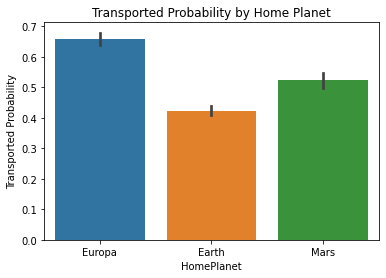

In [293]:
sns.barplot(x = 'HomePlanet', y ='Transported', data = train_data)
plt.ylabel('Transported Probability')
plt.title('Transported Probability by Home Planet')

In [294]:
# train_data.CryoSleep.value_counts(dropna=False)

In [295]:
# train_data[['CryoSleep', 'Transported']].groupby("CryoSleep", as_index=False).mean().sort_values(by="Transported", ascending=False)


Text(0, 0.5, 'Transported Probability by CryoSleep')

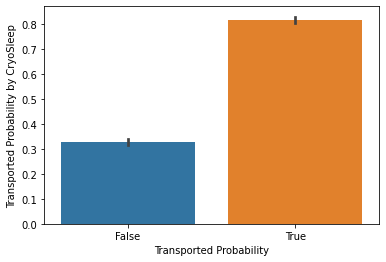

In [296]:

sns.barplot(x="CryoSleep", y="Transported", data=train_data)
plt.xlabel("Transported Probability")
plt.ylabel("Transported Probability by CryoSleep")

In [297]:
# train_data.VIP.value_counts(dropna=False)

In [298]:

# train_data[['VIP', 'Transported']].groupby("VIP", as_index=False).mean().sort_values(by="Transported", ascending=False)



Text(0, 0.5, 'Transported Probability by VIP')

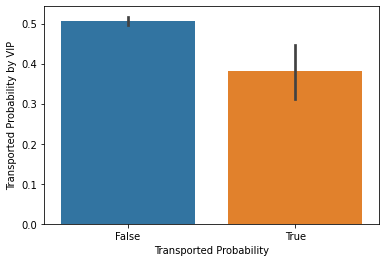

In [299]:

sns.barplot(x="VIP", y="Transported", data=train_data)
plt.xlabel("Transported Probability")
plt.ylabel("Transported Probability by VIP")

In [300]:
train_data['Transported'].replace(False, 0, inplace=True)
train_data['Transported'].replace(True, 1, inplace=True)

train_data.Transported = train_data.Transported.astype(int)

train_data['VIP'].replace(False, 0, inplace=True)
train_data['VIP'].replace(True, 1, inplace=True)
test_data['VIP'].replace(False, 0, inplace=True)
test_data['VIP'].replace(True, 1, inplace=True)

test_data.VIP = test_data.VIP.astype("Int8")
train_data.VIP = train_data.VIP.astype("Int8")

train_data.CryoSleep.replace(False, 0, inplace=True)
test_data.CryoSleep.replace(False, 0, inplace=True)

train_data.CryoSleep.replace(True, 1, inplace=True)
test_data.CryoSleep.replace(True, 1, inplace=True)

test_data.CryoSleep = test_data.CryoSleep.astype("Int8")
train_data.CryoSleep = train_data.CryoSleep.astype("Int8")


In [301]:
train_data[['deck','num', 'side']] = train_data['Cabin'].str.split('/', expand=True)
test_data[['deck','num', 'side']] = test_data['Cabin'].str.split('/', expand=True)

train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

In [302]:
col_to_sum = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train_data['SumSpends'] = train_data[col_to_sum].sum(axis=1)
test_data['SumSpends'] = test_data[col_to_sum].sum(axis=1)

train_data['MaxSpends'] = train_data[col_to_sum].max(axis=1)
test_data['MaxSpends'] = test_data[col_to_sum].max(axis=1)

In [303]:
train_data['log_spend'] = np.log(train_data.SumSpends + 1)
test_data['log_spend'] = np.log(test_data.SumSpends + 1)



In [304]:

null_cols = train_data.isnull().sum().sort_values(ascending=False)
null_cols = list(null_cols[null_cols>1].index)

In [305]:


object_cols = [col for col in train_data.columns if train_data[col].dtype == 'object' or train_data[col].dtype == 'category']



oc = OrdinalEncoder()

df_for_encode = pd.concat([train_data, test_data])

df_for_encode[object_cols] = df_for_encode[object_cols].astype('category')

df_for_encode[object_cols] = oc.fit_transform(df_for_encode[object_cols])

del train_data, test_data

train_data = df_for_encode.iloc[:8693, :]
test_data = df_for_encode.iloc[8693: , :]

del df_for_encode

test_data.drop('Transported', inplace=True, axis=1)

In [306]:


ct = ColumnTransformer([("imp", SimpleImputer(strategy='mean'), null_cols)])

train_data[null_cols] = ct.fit_transform(train_data[null_cols])
test_data[null_cols] = ct.transform(test_data[null_cols])

In [307]:
train_data.drop('PassengerId', axis=1, inplace = True)
test_data.drop('PassengerId', axis=1, inplace = True)

y_train = train_data['Transported']
X_train = train_data.drop('Transported', axis=1)
X_test = test_data

if X_train.shape[1] == X_test.shape[1]:
    print('As shapes are equal we can train our model.')
else:
    print('Something happened in the model check once.')

As shapes are equal we can train our model.


In [343]:


cv = StratifiedKFold(n_splits = 9, shuffle=True, random_state=42)
fold_accuracy = []
for tr_idx, val_idx in cv.split(X_train, y_train):
    X_tr, y_tr, X_val, y_val = X_train.iloc[tr_idx], y_train.iloc[tr_idx], X_train.iloc[val_idx], y_train.iloc[val_idx]
    model = CatBoostClassifier(eval_metric = 'Accuracy', verbose=0, rsm = 0.79, iterations = 1000)
    model.fit(X_tr, y_tr)
    pred_fold = model.predict(X_val)
    fold_accuracy.append(accuracy_score(pred_fold, y_val))

print(f'Accuracy = {np.mean(fold_accuracy)}')
print(f'fold accuracy: {fold_accuracy}')

Accuracy = 0.8147916912503531
fold accuracy: [0.8157349896480331, 0.8322981366459627, 0.8281573498964804, 0.7950310559006211, 0.8167701863354038, 0.8115942028985508, 0.8188405797101449, 0.8157349896480331, 0.7989637305699482]


In [344]:
predictions = pd.DataFrame({})
for i in range(20):
    catb = CatBoostClassifier(eval_metric = 'Accuracy', verbose=0, rsm = 0.81, iterations = 1000, random_seed = i*7 + 4)
    catb.fit(X_train, y_train)
    print(f"Train accuracy: {accuracy_score(y_train, catb.predict(X_train))}")
    predictions[f"CATB_{i}"] = catb.predict_proba(X_test)[:, 1]

Train accuracy: 0.8863453353272748
Train accuracy: 0.8873806510985851
Train accuracy: 0.8854250546416657
Train accuracy: 0.8885310019555964
Train accuracy: 0.8863453353272748
Train accuracy: 0.8873806510985851
Train accuracy: 0.8868054756700794
Train accuracy: 0.8843897388703554
Train accuracy: 0.8847348441274588
Train accuracy: 0.8872656160128839
Train accuracy: 0.8857701598987692
Train accuracy: 0.8860002300701714
Train accuracy: 0.8877257563556885
Train accuracy: 0.8862303002415737
Train accuracy: 0.8854250546416657
Train accuracy: 0.886460370412976
Train accuracy: 0.8839295985275509
Train accuracy: 0.8860002300701714
Train accuracy: 0.8863453353272748
Train accuracy: 0.8863453353272748


In [345]:
from xgboost import XGBClassifier
fold_accuracy = []
for tr_idx, val_idx in cv.split(X_train, y_train):
    X_tr, y_tr, X_val, y_val = X_train.iloc[tr_idx], y_train.iloc[tr_idx], X_train.iloc[val_idx], y_train.iloc[val_idx]
    model = XGBClassifier(max_depth = 6, subsample = 0.75, n_estimators = 650, learning_rate = 0.03, min_child_weight = 0.9, random_state = 1)
    model.fit(X_tr, y_tr)
    pred_fold = model.predict(X_val)
    fold_accuracy.append(accuracy_score(pred_fold, y_val))

print(f'Accuracy = {np.mean(fold_accuracy)}')
print(f'fold accuracy: {fold_accuracy}')

Accuracy = 0.8057035344487473
fold accuracy: [0.8043478260869565, 0.8229813664596274, 0.8209109730848861, 0.7971014492753623, 0.7950310559006211, 0.7981366459627329, 0.8157349896480331, 0.8105590062111802, 0.7865284974093264]


In [354]:
for i in range(20):
    xgb = XGBClassifier(max_depth = 6, subsample = 0.75, n_estimators = 750, learning_rate = 0.03, min_child_weight = 0.9, random_state = i*2 + 1)
    xgb.fit(X_train, y_train)
    print(f"Train Accuracy: {accuracy_score(y_train, xgb.predict(X_train))}")
    predictions[f"XGB_{i}"] = xgb.predict_proba(X_test)[:, 1]

Train Accuracy: 0.946968825491775
Train Accuracy: 0.9457034395490624
Train Accuracy: 0.9466237202346716
Train Accuracy: 0.9468537904060739
Train Accuracy: 0.9465086851489705
Train Accuracy: 0.9451282641205567
Train Accuracy: 0.9482342114344875
Train Accuracy: 0.9461635798918671
Train Accuracy: 0.9463936500632693
Train Accuracy: 0.9454733693776601
Train Accuracy: 0.9459335097204647
Train Accuracy: 0.9452432992062579
Train Accuracy: 0.9475440009202807
Train Accuracy: 0.9455884044633613
Train Accuracy: 0.9473139307488784
Train Accuracy: 0.9463936500632693
Train Accuracy: 0.9499597377200046
Train Accuracy: 0.9480041412630852
Train Accuracy: 0.9476590360059818
Train Accuracy: 0.946968825491775


In [355]:
from lightgbm import LGBMClassifier
fold_accuracy = []
for tr_idx, val_idx in cv.split(X_train, y_train):
    X_tr, y_tr, X_val, y_val = X_train.iloc[tr_idx], y_train.iloc[tr_idx], X_train.iloc[val_idx], y_train.iloc[val_idx]
    model = LGBMClassifier(min_child_weight=0.8, random_state=1, n_estimators=750, learning_rate = 0.01, subsample=0.7, subsample_freq=1, colsample_bytree = 0.85)
    model.fit(X_tr, y_tr)
    pred_fold = model.predict(X_val)
    fold_accuracy.append(accuracy_score(pred_fold, y_val))

print(f'Accuracy = {np.mean(fold_accuracy)}')
print(f'fold accuracy: {fold_accuracy}')

Accuracy = 0.8109948973206464
fold accuracy: [0.8074534161490683, 0.8250517598343685, 0.8250517598343685, 0.7950310559006211, 0.7991718426501035, 0.8115942028985508, 0.8229813664596274, 0.8229813664596274, 0.7896373056994819]


In [356]:
for i in range(10):
    lgb = LGBMClassifier(min_child_weight=0.8, random_state=i*5 + 6, n_estimators=750, learning_rate = 0.01, subsample=0.7, subsample_freq=1, colsample_bytree = 0.85)
    lgb.fit(X_train, y_train)
    print(f"Train Accuracy: {accuracy_score(y_train, lgb.predict(X_train))}")
    predictions[f"LGB_{i}"] = lgb.predict_proba(X_test)[:, 1]

Train Accuracy: 0.8742666513286552
Train Accuracy: 0.8747267916714598
Train Accuracy: 0.8754170021856666
Train Accuracy: 0.8755320372713677
Train Accuracy: 0.8755320372713677
Train Accuracy: 0.875647072357069
Train Accuracy: 0.8748418267571609
Train Accuracy: 0.8741516162429541
Train Accuracy: 0.875647072357069
Train Accuracy: 0.8774876337282871


In [357]:
nn_pred_data = pd.read_csv('/kaggle/input/neural/neural3.csv')

In [358]:
predictions

,CATB_0,CATB_1,CATB_2,CATB_3,CATB_4,CATB_5,CATB_6,CATB_7,CATB_8,CATB_9,...,LGB_0,LGB_1,LGB_2,LGB_3,LGB_4,LGB_5,LGB_6,LGB_7,LGB_8,LGB_9
0,0.493933,0.504908,0.491417,0.500511,0.492284,0.496201,0.515241,0.522509,0.515602,0.506432,...,0.490452,0.479537,0.486404,0.472625,0.472651,0.492687,0.456696,0.497753,0.493085,0.477128
1,0.007730,0.008037,0.008644,0.009873,0.009901,0.009218,0.007958,0.010740,0.009183,0.009467,...,0.021393,0.020177,0.022796,0.019360,0.021535,0.019346,0.020716,0.021048,0.020629,0.023294
2,0.988234,0.988984,0.991364,0.986762,0.986544,0.988077,0.989596,0.987130,0.987816,0.991324,...,0.986448,0.984492,0.987140,0.984669,0.986959,0.984420,0.982720,0.987228,0.985074,0.985841
3,0.979913,0.968050,0.971249,0.972475,0.974309,0.970654,0.971820,0.972226,0.977960,0.973641,...,0.983522,0.981571,0.982264,0.977982,0.982441,0.981168,0.983101,0.983719,0.984720,0.980968
4,0.409896,0.440131,0.435870,0.423489,0.432761,0.455989,0.440313,0.409862,0.432670,0.476516,...,0.541453,0.555361,0.551127,0.496615,0.556235,0.539918,0.560336,0.552039,0.510107,0.555092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.604760,0.580432,0.591051,0.578652,0.570227,0.572634,0.582541,0.560804,0.590236,0.587841,...,0.578385,0.572413,0.565021,0.577039,0.553233,0.579000,0.564874,0.565414,0.571475,0.567927
4273,0.335972,0.296631,0.370770,0.368712,0.383971,0.400902,0.376792,0.373916,0.370824,0.370531,...,0.347278,0.354356,0.345978,0.302711,0.296403,0.358515,0.371346,0.364369,0.330893,0.323763
4274,0.914578,0.926323,0.917953,0.915664,0.919243,0.928023,0.922479,0.927929,0.910327,0.930035,...,0.955272,0.960098,0.954947,0.953191,0.952311,0.947314,0.960643,0.959103,0.959340,0.956095
4275,0.821303,0.828823,0.802899,0.835655,0.798708,0.831876,0.849012,0.807943,0.819247,0.812565,...,0.812160,0.773181,0.790914,0.788213,0.769748,0.761442,0.772428,0.797512,0.784207,0.773666


In [359]:
cat_preds = predictions.iloc[:, :10].mean(axis=1)
xgb_preds = predictions.iloc[:,10:20].mean(axis=1)
lgb_preds = predictions.iloc[:, 20:].mean(axis=1)
nn_preds = nn_pred_data.mean(axis=1)

In [360]:
final_preds = cat_preds * (1/6)  + lgb_preds * (1/6) + xgb_preds * (1/6)+ nn_preds * (1/2)

In [362]:
sample = pd.read_csv(f'/kaggle/input/spaceship-titanic/sample_submission.csv')

sample.Transported = final_preds > 0.5
sample.to_csv("f2submission.csv", index = False)